In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

## CatBoost 진행
1. 랜덤 언더 샘플링 데이터
2. SMOTE-NC 데이터
3. SMOTE-NC + 랜덤 언더 샘플링 데이터
4. 가중치

모델링 과정은 기본 파라미터로 일단 진행됨.

### 1. 랜덤 언더 샘플링 데이터로 CAT 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [4]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/randomunder_modeling/train.csv")
test = pd.read_csv("data/train/randomunder_modeling/test.csv")

CatBoost 학습

In [5]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6821265	total: 157ms	remaining: 2m 36s
1:	learn: 0.6715672	total: 174ms	remaining: 1m 26s
2:	learn: 0.6620335	total: 195ms	remaining: 1m 4s
3:	learn: 0.6538409	total: 212ms	remaining: 52.8s
4:	learn: 0.6458380	total: 264ms	remaining: 52.5s
5:	learn: 0.6383034	total: 301ms	remaining: 49.9s
6:	learn: 0.6322618	total: 331ms	remaining: 47s
7:	learn: 0.6258236	total: 351ms	remaining: 43.5s
8:	learn: 0.6202641	total: 365ms	remaining: 40.2s
9:	learn: 0.6148841	total: 380ms	remaining: 37.7s
10:	learn: 0.6089928	total: 417ms	remaining: 37.5s
11:	learn: 0.6041250	total: 456ms	remaining: 37.6s
12:	learn: 0.5993582	total: 477ms	remaining: 36.2s
13:	learn: 0.5951858	total: 498ms	remaining: 35s
14:	learn: 0.5909986	total: 532ms	remaining: 35s
15:	learn: 0.5875805	total: 563ms	remaining: 34.7s
16:	learn: 0.5844212	total: 582ms	remaining: 33.6s
17:	learn: 0.5814169	total: 610ms	remaining: 33.3s
18:	learn: 0.5778725	total: 626ms	remaining: 32.3s
19:	learn: 0.5749776	total: 638ms	remaining: 

Test Accuracy: 0.80

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1932419
           1       0.03      0.74      0.05     13176

    accuracy                           0.80   1945595
   macro avg       0.51      0.77      0.47   1945595
weighted avg       0.99      0.80      0.88   1945595


Confusion Matrix (테스트 데이터):
[[1553465  378954]
 [   3425    9751]]


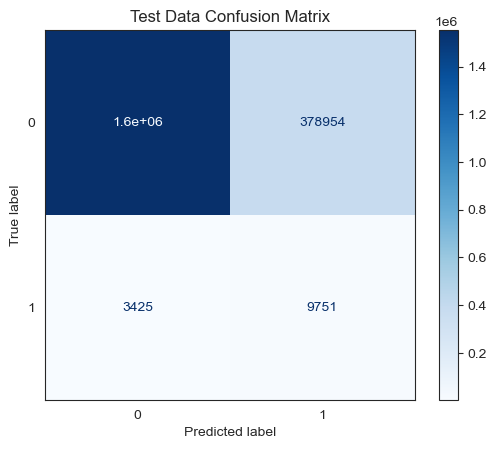

Test AUC-ROC: 0.85


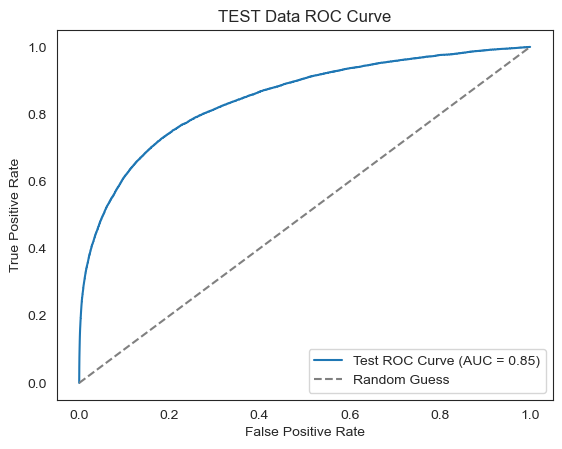

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = cat_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=cat_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = cat_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

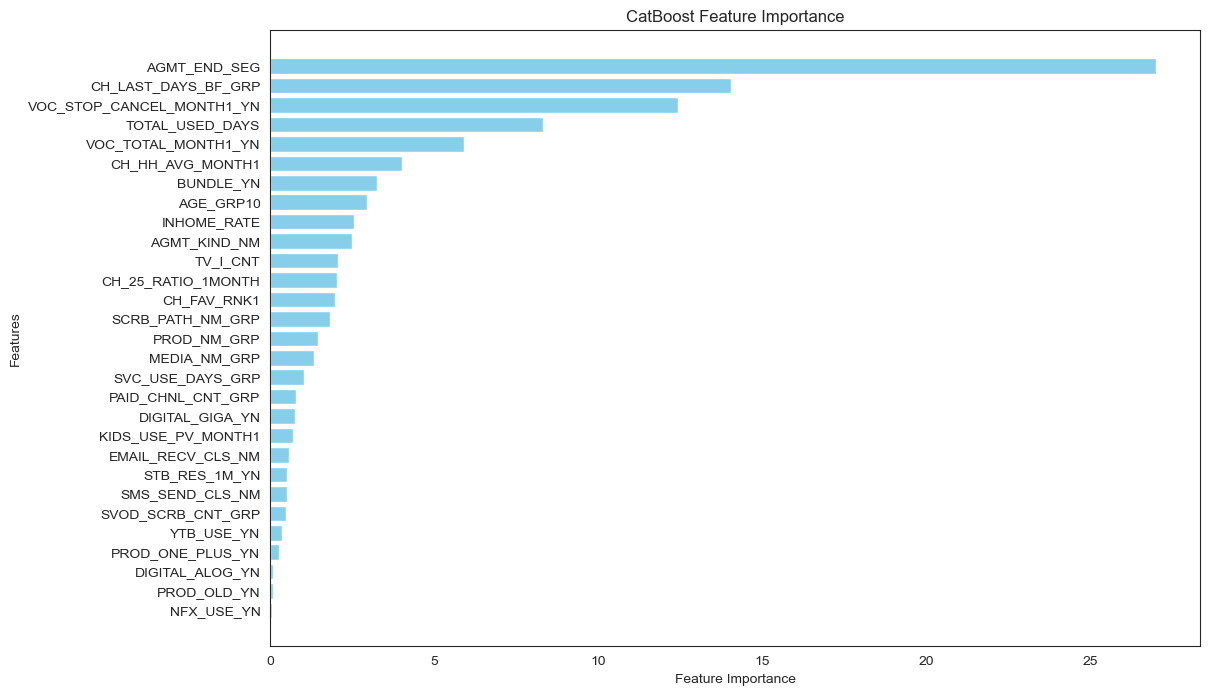

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


---

### 2. SMOTE-NC 데이터로 CatBoost 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [9]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smote_modeling/train.csv")
test = pd.read_csv("data/train/smote_modeling/test.csv")

CatBoost 학습

In [10]:
from catboost import CatBoostClassifier

X_train = train.drop(columns=['churn'])
y_train = train['churn']

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

cat_model.fit(X_train, y_train)

0:	learn: 0.6773221	total: 1.1s	remaining: 18m 15s
1:	learn: 0.6620040	total: 2.29s	remaining: 19m 5s
2:	learn: 0.6486060	total: 3.47s	remaining: 19m 13s
3:	learn: 0.6355061	total: 4.61s	remaining: 19m 8s
4:	learn: 0.6236640	total: 6.12s	remaining: 20m 18s
5:	learn: 0.6123607	total: 7.4s	remaining: 20m 26s
6:	learn: 0.6017373	total: 8.85s	remaining: 20m 55s
7:	learn: 0.5934234	total: 10.2s	remaining: 21m 1s
8:	learn: 0.5848248	total: 12.1s	remaining: 22m 8s
9:	learn: 0.5761954	total: 13.6s	remaining: 22m 27s
10:	learn: 0.5692204	total: 14.5s	remaining: 21m 43s
11:	learn: 0.5632133	total: 15.5s	remaining: 21m 12s
12:	learn: 0.5538787	total: 16.4s	remaining: 20m 46s
13:	learn: 0.5461099	total: 18s	remaining: 21m 8s
14:	learn: 0.5408890	total: 19.4s	remaining: 21m 17s
15:	learn: 0.5352150	total: 20.5s	remaining: 21m
16:	learn: 0.5300458	total: 21.4s	remaining: 20m 36s
17:	learn: 0.5251151	total: 22.4s	remaining: 20m 19s
18:	learn: 0.5212805	total: 23.1s	remaining: 19m 55s
19:	learn: 0.514

Test Accuracy: 0.88

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.88      0.94   1932419
           1       0.03      0.44      0.05     13176

    accuracy                           0.88   1945595
   macro avg       0.51      0.66      0.49   1945595
weighted avg       0.99      0.88      0.93   1945595


Confusion Matrix (테스트 데이터):
[[1710119  222300]
 [   7422    5754]]


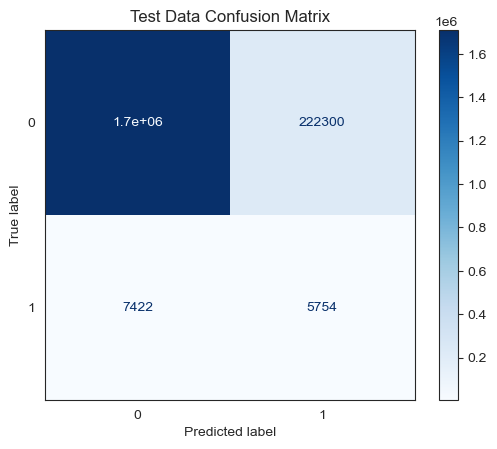

Test AUC-ROC: 0.74


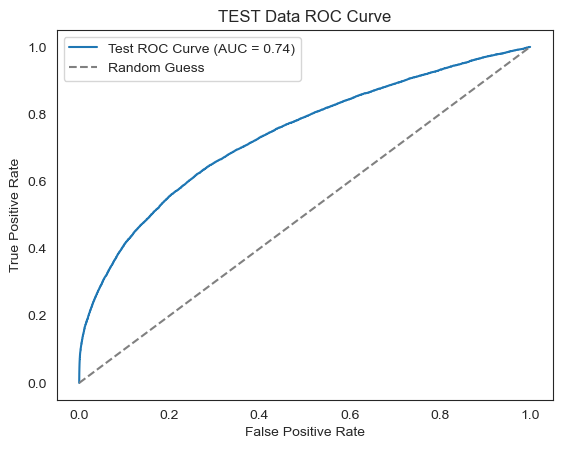

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = cat_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=cat_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = cat_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

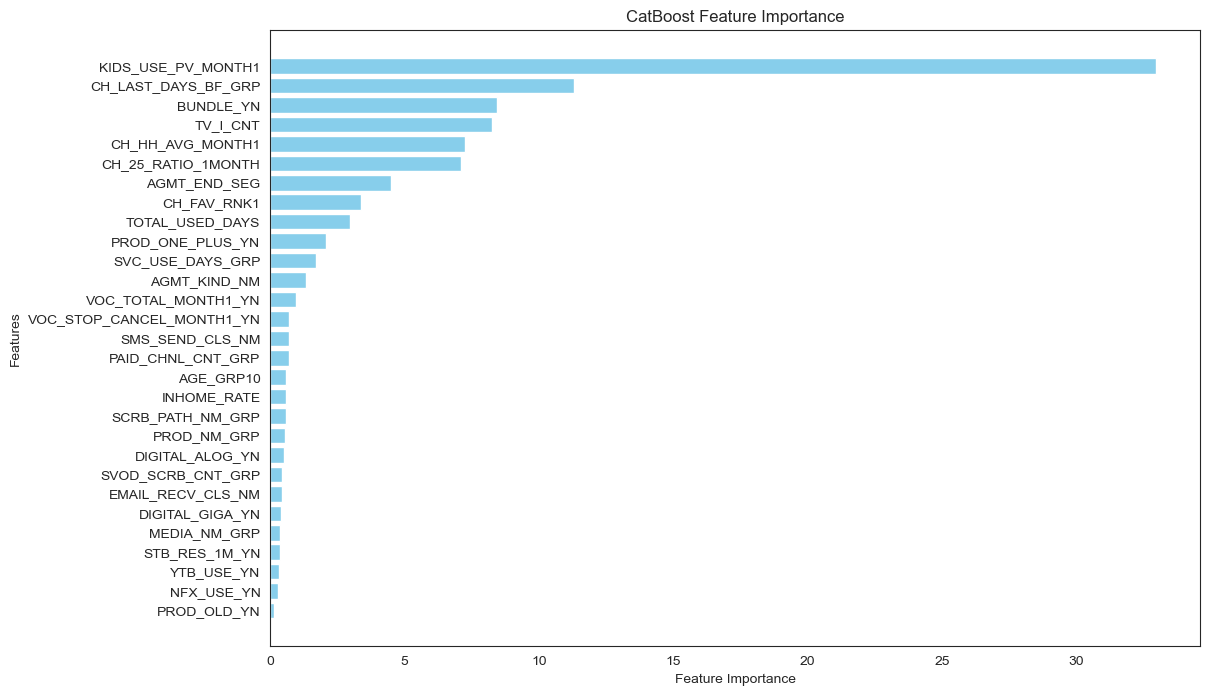

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 3. SMOTE-NC + 랜덤 언더 샘플링 데이터로 CatBoost 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [14]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smoterandom_modeling/train.csv")
test = pd.read_csv("data/train/smoterandom_modeling/test.csv")

LGBM 학습

In [15]:
from catboost import CatBoostClassifier

X_train = train.drop(columns=['churn'])
y_train = train['churn']

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

cat_model.fit(X_train, y_train)

0:	learn: 0.6750944	total: 840ms	remaining: 13m 58s
1:	learn: 0.6592288	total: 1.7s	remaining: 14m 5s
2:	learn: 0.6440390	total: 2.37s	remaining: 13m 6s
3:	learn: 0.6299341	total: 3.09s	remaining: 12m 50s
4:	learn: 0.6176206	total: 3.79s	remaining: 12m 34s
5:	learn: 0.6054795	total: 4.47s	remaining: 12m 20s
6:	learn: 0.5951195	total: 5.18s	remaining: 12m 15s
7:	learn: 0.5847498	total: 5.86s	remaining: 12m 6s
8:	learn: 0.5765122	total: 6.53s	remaining: 11m 59s
9:	learn: 0.5680998	total: 7.21s	remaining: 11m 53s
10:	learn: 0.5584953	total: 7.89s	remaining: 11m 49s
11:	learn: 0.5518412	total: 8.55s	remaining: 11m 43s
12:	learn: 0.5434730	total: 9.43s	remaining: 11m 56s
13:	learn: 0.5352130	total: 10.2s	remaining: 11m 55s
14:	learn: 0.5292416	total: 10.8s	remaining: 11m 52s
15:	learn: 0.5231268	total: 11.5s	remaining: 11m 49s
16:	learn: 0.5181203	total: 12.2s	remaining: 11m 44s
17:	learn: 0.5140010	total: 12.8s	remaining: 11m 40s
18:	learn: 0.5083063	total: 13.6s	remaining: 11m 42s
19:	lea

Test Accuracy: 0.91

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.92      0.95   1932419
           1       0.03      0.38      0.06     13176

    accuracy                           0.91   1945595
   macro avg       0.51      0.65      0.51   1945595
weighted avg       0.99      0.91      0.95   1945595


Confusion Matrix (테스트 데이터):
[[1771766  160653]
 [   8189    4987]]


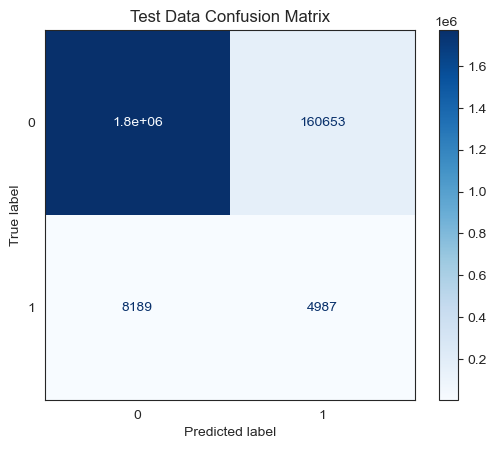

Test AUC-ROC: 0.74


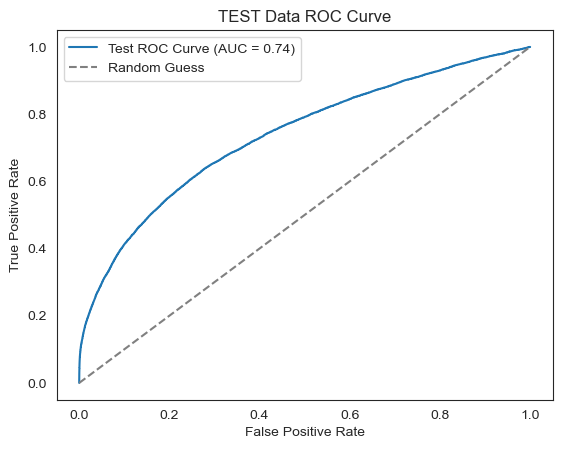

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = cat_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=cat_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = cat_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

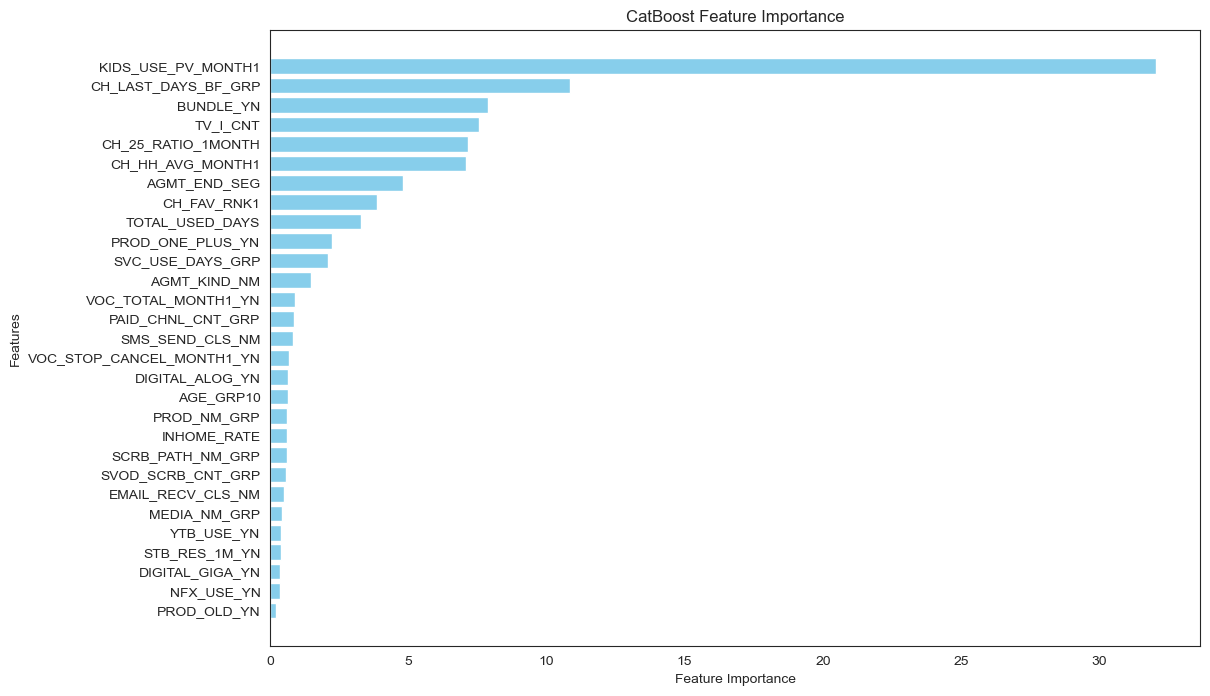

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 4. 가중치로 CatBoost 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [19]:
train = pd.read_csv("data/train/train_weights.csv")
test = pd.read_csv("data/train/test.csv")

In [20]:
display(train)
display(test)

,sha2_hash,p_mt,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,4,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.00,약정만료전 9~12개월,20240325,794,Y,Y,N,3.00,3주일전,N,N,60대,수신,수신,9.86,기타,0.00,N,N,N,3.71
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,5,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.00,약정만료전 9~12개월,20240325,825,Y,Y,N,3.00,4주일전,N,N,60대,수신,수신,5.95,기타,0.00,N,N,N,3.57
2,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,4,12개월~24개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,30.00,약정만료전 12개월이상,20240616,4188,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,7.94,기타,0.00,N,N,N,0.12
3,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,5,12개월~24개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,50.00,약정만료전 12개월이상,20240616,4219,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,18.21,기타,0.00,N,N,N,0.02
4,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,4,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,20.00,약정만료전 12개월이상,20250718,2427,Y,N,N,6.00,일주일내,Y,N,60대,수신,수신,1.39,기타,0.00,N,N,N,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914836,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,5,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.00,약정만료후 12개월이상,20141014,3775,N,N,N,2.00,일주일내,N,N,30대,전체거부,전체거부,0.85,기타,0.00,N,N,N,0.02
3914837,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,4,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1338,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,4.54,기타,1.00,N,N,N,0.51
3914838,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,5,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1369,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,5.79,기타,0.00,N,N,N,0.40
3914839,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,4,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.00,약정만료후 12개월이상,20200405,2215,N,N,N,1.00,일주일내,N,N,50대,수신,수신,2.42,KBS2,0.00,N,N,N,0.00


,sha2_hash,p_mt,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,11,24개월~ 36개월미만,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20260820,1008,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,6.23,기타,0.00,N,N,N,4.72
1,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,11,24개월~ 36개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,70.00,약정만료전 6~9개월,20240616,4402,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,15.37,기타,1.00,N,N,N,0.48
2,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,11,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,10.00,약정만료전 12개월이상,20250718,2641,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.47,기타,1.00,N,N,N,2.97
3,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,11,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,10.00,약정만료후 9~12개월,20230127,1989,N,N,N,3.00,일주일내,N,N,60대,수신,수신,2.16,기타,0.00,N,N,N,11.85
4,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,11,36개월 이상,HD,프리미엄,N,Y,신규,N,1건,1건,현장경로,0.00,약정만료후 12개월이상,20190828,3979,Y,N,N,4.00,일주일내,Y,N,50대,수신,수신,1.64,기타,0.00,N,N,N,2.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945590,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,11,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.00,약정만료후 12개월이상,20191114,3599,N,N,N,2.00,3개월내없음,N,N,50대,수신,수신,0.00,기타,0.00,N,N,N,0.00
1945591,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,11,36개월 이상,HD,이코노미,N,N,신규,N,1건,0건,O/B,10.00,약정만료후 12개월이상,20200831,2281,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,1.81,MBN,0.00,N,N,N,4.40
1945592,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,11,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.00,약정만료후 12개월이상,20141014,3958,N,N,N,2.00,일주일내,N,N,30대,수신,수신,1.69,기타,0.00,N,N,N,0.00
1945593,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,11,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1552,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,3.39,기타,0.00,N,N,N,2.42


In [21]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object


In [22]:
train = train.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [23]:
from sklearn.preprocessing import LabelEncoder

train_and_test = pd.concat([train, test])

categorical_cols = train_and_test.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  train_and_test[col] = le.fit_transform(train_and_test[col])
  label_encoders[col] = le

# 인코딩 후, 다시 train과 test로 분리

train = train_and_test.iloc[:len(train)].reset_index(drop=True)
test = train_and_test.iloc[len(train):].reset_index(drop=True)

print("레이블 인코딩 끝! 😁")

레이블 인코딩 끝! 😁


In [24]:
for col, le in label_encoders.items():
    print(f"🔹 {col} 레이블 인코딩 매핑")
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_mapping)
    print("-" * 30)

🔹 SVC_USE_DAYS_GRP 레이블 인코딩 매핑
{'12개월~24개월미만': 0, '24개월~ 36개월미만': 1, '36개월 이상': 2, '6개월~12개월미만': 3, '6개월미만': 4}
------------------------------
🔹 MEDIA_NM_GRP 레이블 인코딩 매핑
{'HD': 0, 'UHD': 1, '기타': 2}
------------------------------
🔹 PROD_NM_GRP 레이블 인코딩 매핑
{'기타': 0, '베이직': 1, '세이버': 2, '스탠다드': 3, '이코노미': 4, '프리미엄': 5}
------------------------------
🔹 PROD_OLD_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 PROD_ONE_PLUS_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 AGMT_KIND_NM 레이블 인코딩 매핑
{'신규': 0, '약정갱신': 1, '약정승계': 2, '약정연장': 3, '약정축소': 4, '재약정': 5, '정보없음': 6}
------------------------------
🔹 STB_RES_1M_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 SVOD_SCRB_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 PAID_CHNL_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 SCRB_PATH_NM_GRP 레이블 인코딩 매핑
{'I/B': 0, 'O/B': 1, '기타': 2, '렌탈제휴': 3, '일반상담': 4, '임직원': 5,

In [25]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# boxplot으로 확인한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


CatBoost 학습

In [26]:
from catboost import CatBoostClassifier

# 가중치
# scale_pos_weight_value = train['churn'].value_counts()[0] / train['churn'].value_counts()[1]
# print(f"Calculated class weight for churn=1: {scale_pos_weight_value:.2f}")

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    class_weights=[1, 5]
)

cat_model.fit(X_train, y_train)

0:	learn: 0.6689542	total: 770ms	remaining: 12m 49s
1:	learn: 0.6455999	total: 1.5s	remaining: 12m 30s
2:	learn: 0.6239196	total: 2.22s	remaining: 12m 17s
3:	learn: 0.6069957	total: 2.93s	remaining: 12m 10s
4:	learn: 0.5899124	total: 3.7s	remaining: 12m 16s
5:	learn: 0.5742916	total: 4.37s	remaining: 12m 3s
6:	learn: 0.5596256	total: 5.02s	remaining: 11m 52s
7:	learn: 0.5470217	total: 5.64s	remaining: 11m 39s
8:	learn: 0.5333042	total: 6.34s	remaining: 11m 38s
9:	learn: 0.5220075	total: 7.1s	remaining: 11m 42s
10:	learn: 0.5108674	total: 7.81s	remaining: 11m 42s
11:	learn: 0.5016987	total: 8.4s	remaining: 11m 31s
12:	learn: 0.4934108	total: 9.03s	remaining: 11m 25s
13:	learn: 0.4846890	total: 9.72s	remaining: 11m 24s
14:	learn: 0.4776892	total: 10.4s	remaining: 11m 19s
15:	learn: 0.4698709	total: 11.1s	remaining: 11m 20s
16:	learn: 0.4629189	total: 11.8s	remaining: 11m 21s
17:	learn: 0.4567741	total: 12.5s	remaining: 11m 19s
18:	learn: 0.4512147	total: 13s	remaining: 11m 12s
19:	learn:

Test Accuracy: 0.76

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.76      0.86   1932419
           1       0.02      0.58      0.03     13176

    accuracy                           0.76   1945595
   macro avg       0.51      0.67      0.45   1945595
weighted avg       0.99      0.76      0.86   1945595


Confusion Matrix (테스트 데이터):
[[1473302  459117]
 [   5559    7617]]


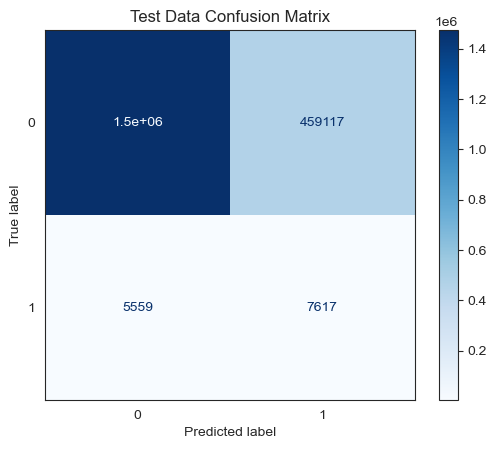

Test AUC-ROC: 0.73


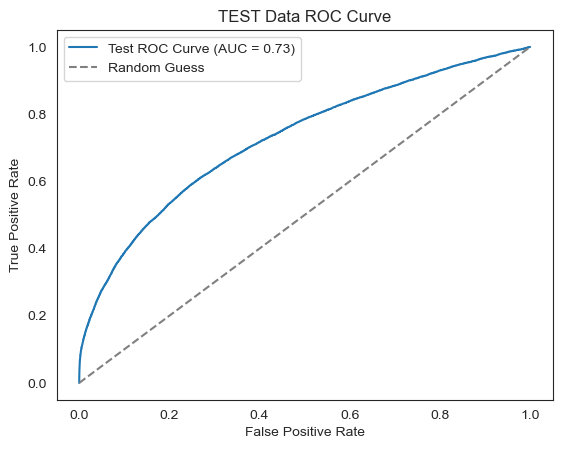

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = cat_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=cat_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = cat_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

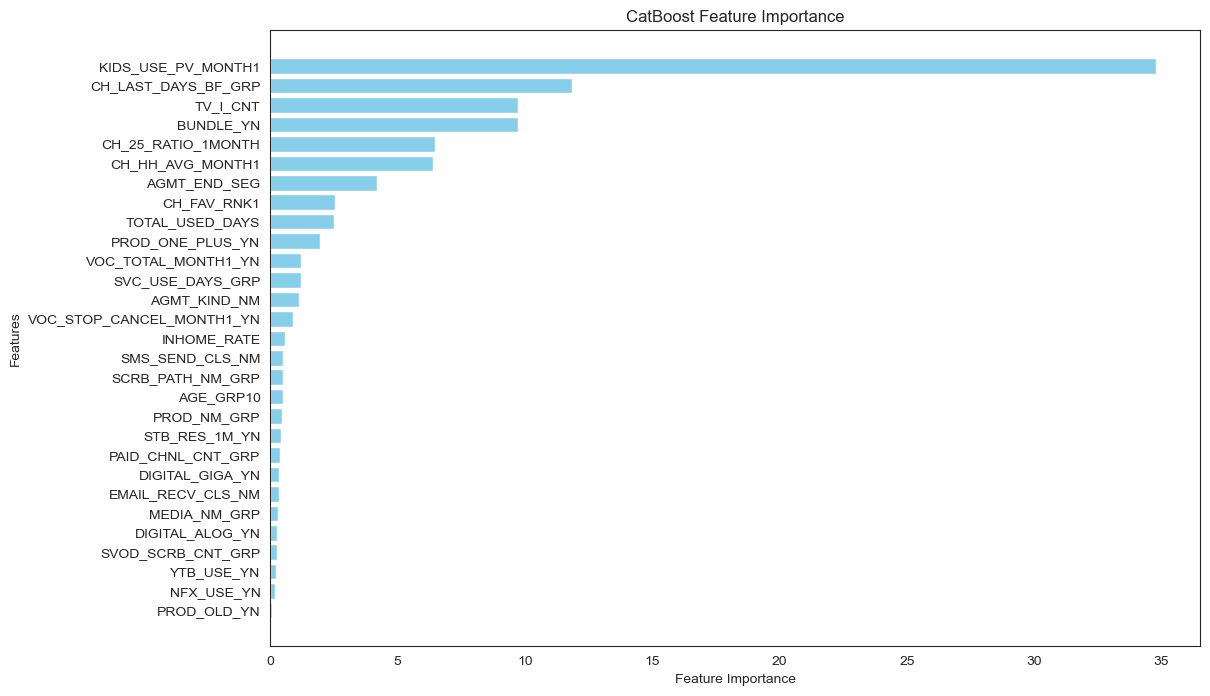

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### 결론
CatBoost는 랜덤 언더를 했을 때, 가장 좋다

### 📌 CatBoost 성능 비교 (Sampling 기법별)

| 샘플링 기법             | Accuracy | 1의 Recall | ROC-AUC |
|------------------------|----------|-----------|---------|
| <span style="color:red;">**랜덤 언더샘플링**</span>     | 0.80     | 0.72      | 0.84    |
| **SMOTE**              | 0.88     | 0.44      | 0.74    |
| **SMOTE + 랜덤 언더샘플링** | 0.91     | 0.38      | 0.74    |
| **가중치 조정**      | 0.76     | 0.58      | 0.73    |